In [1]:
!pip install fvcore

MIEL-HAR with Attention-to-Attention (A²)
Device: cuda



/tmp/ipython-input-1261167356.py:438: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("subject_id", group_keys=False).apply(_fill_subject_group)


PAMAP2 windows ready (MAG removed)
  X shape : (30353, 27, 128) (N,C,T)  C=27
  y shape : (30353,) (N,)
  Classes : 12
--------------------------------------------------------------------------------
Epoch    LR         Total      Cls        E          TestF1(macro)  Best  
--------------------------------------------------------------------------------
10       0.000500   0.5780     0.5359     0.4216     0.9116               
20       0.000500   0.5008     0.4700     0.3078     0.9258               
30       0.000500   0.4563     0.4299     0.2637     0.9351               
40       0.000500   0.4249     0.4011     0.2383     0.9405               
50       0.000500   0.4038     0.3819     0.2185     0.9565         *     
60       0.000500   0.3868     0.3665     0.2032     0.9542               
70       0.000500   0.3725     0.3537     0.1878     0.9503               
80       0.000500   0.3605     0.3430     0.1751     0.9518               
90       0.000500   0.3522     0.3359     0.

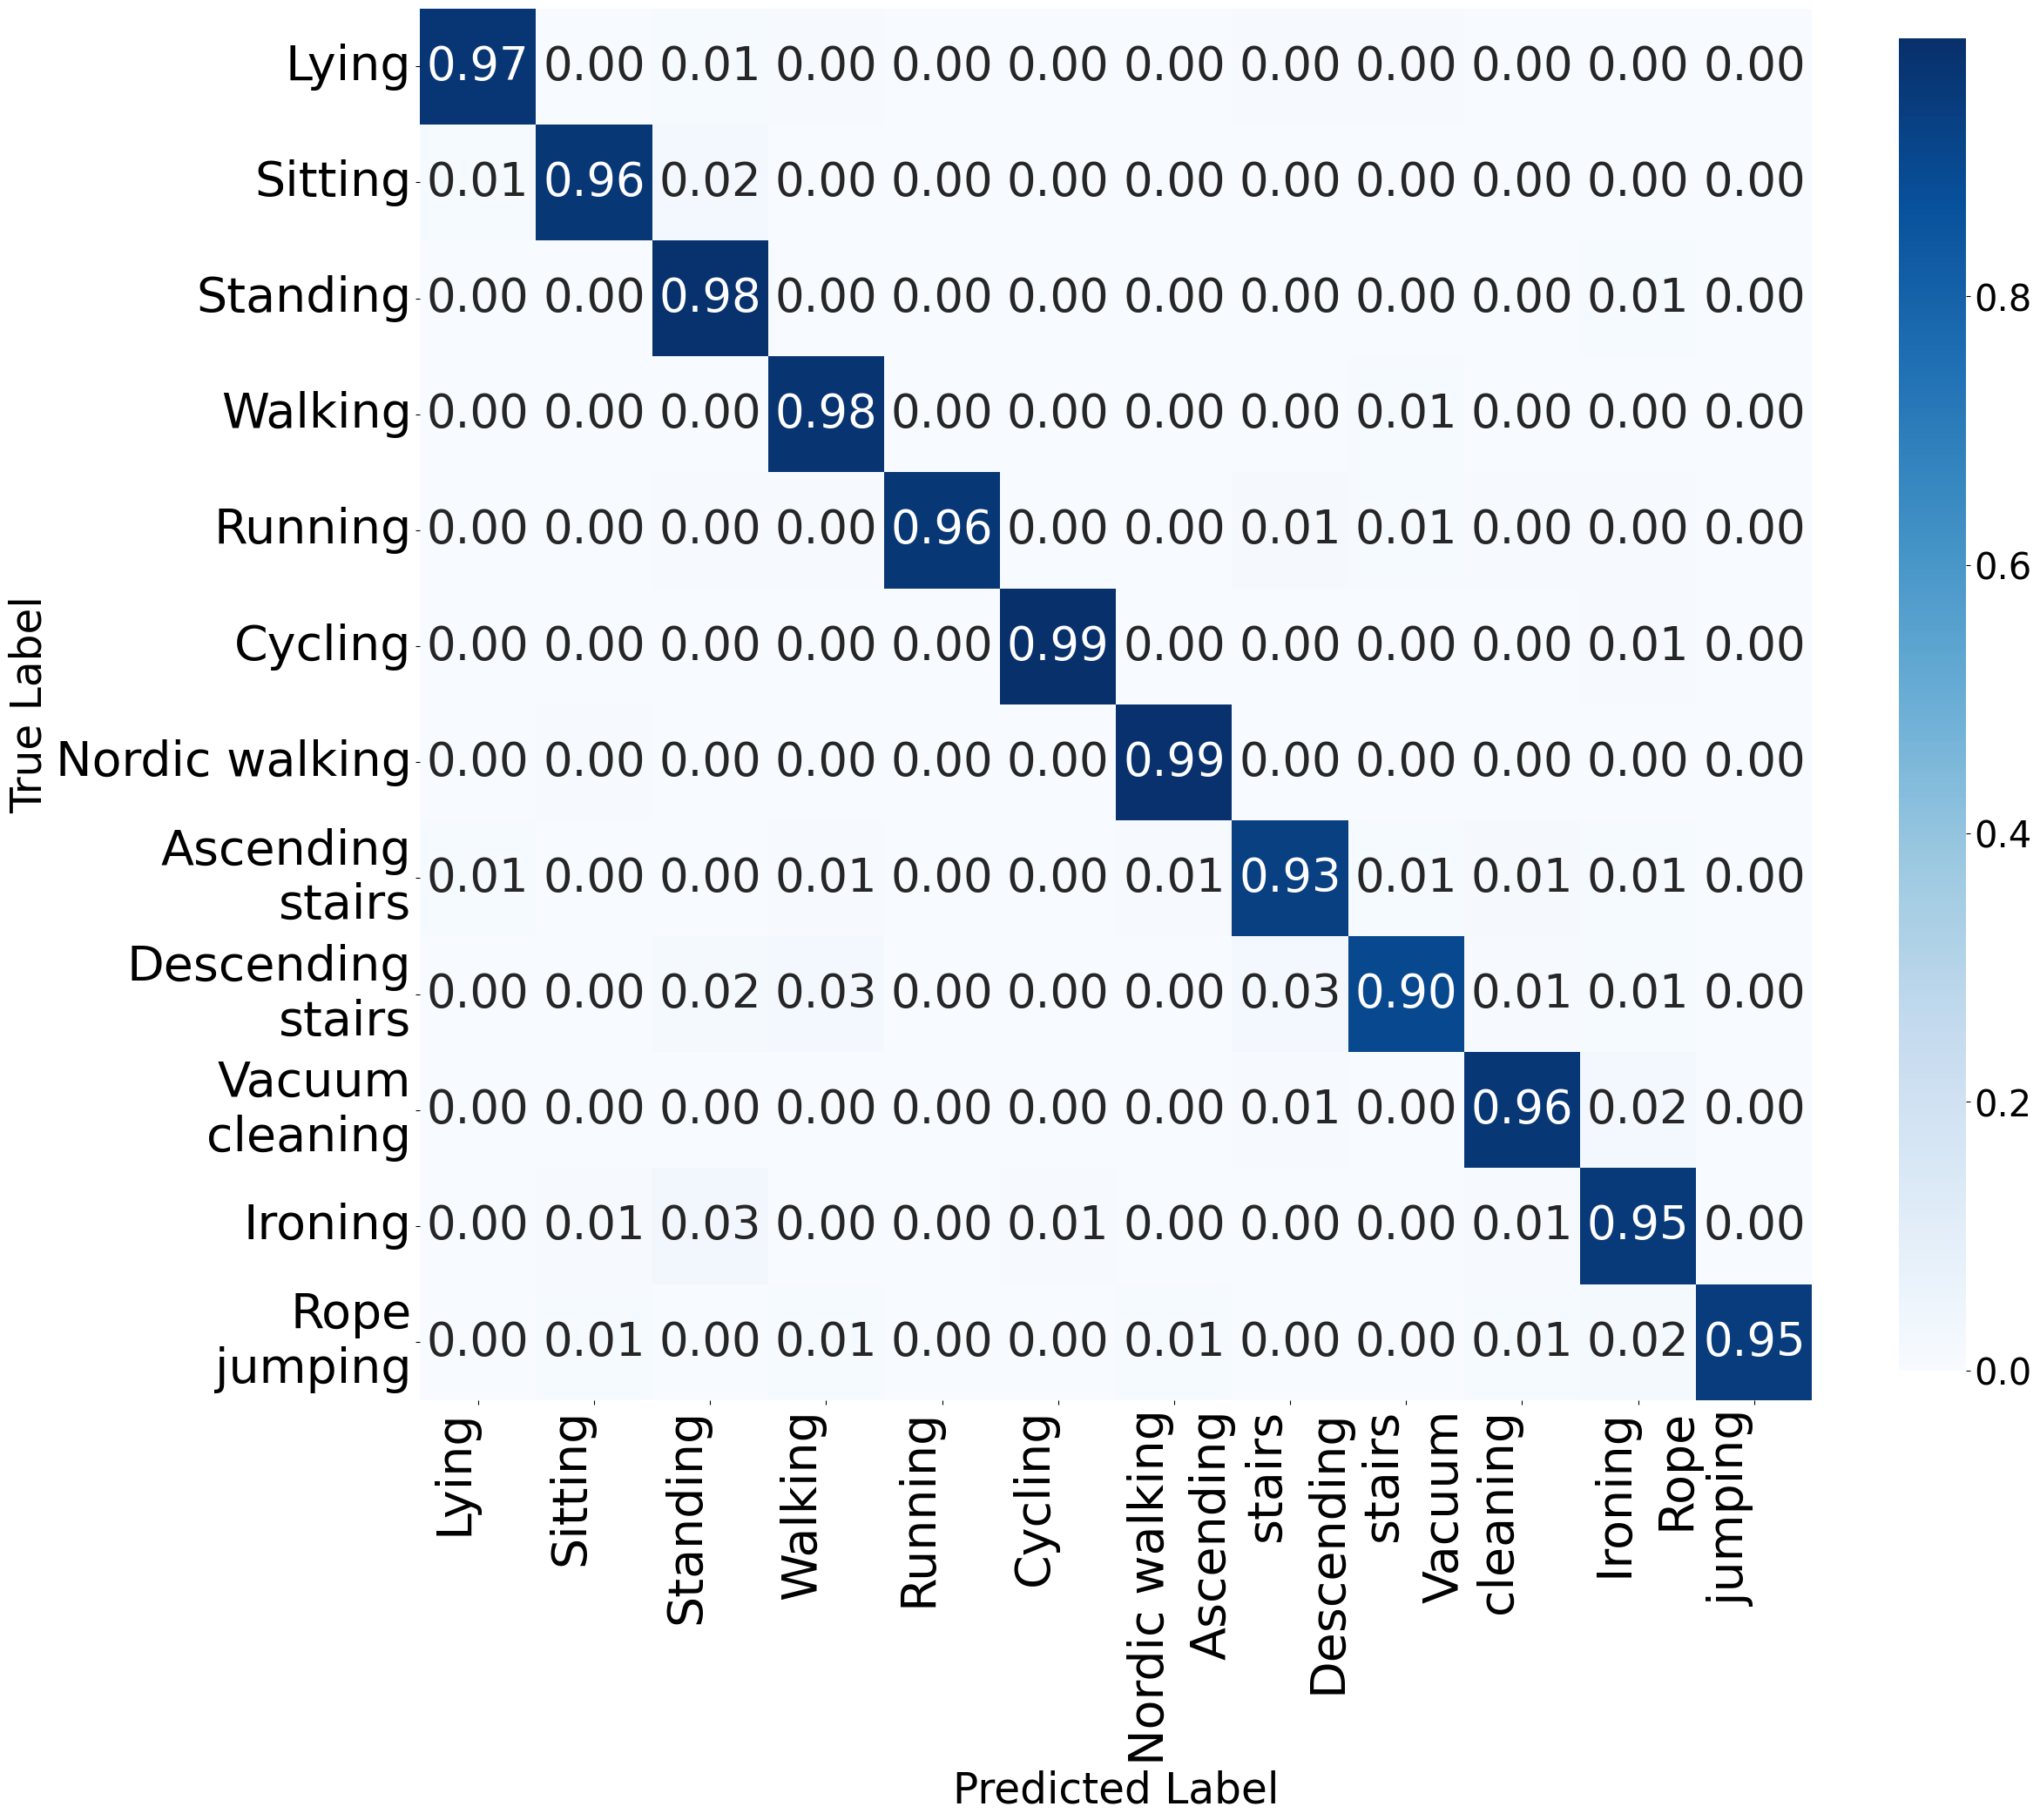


Running Raw Data t-SNE on 2000 points...


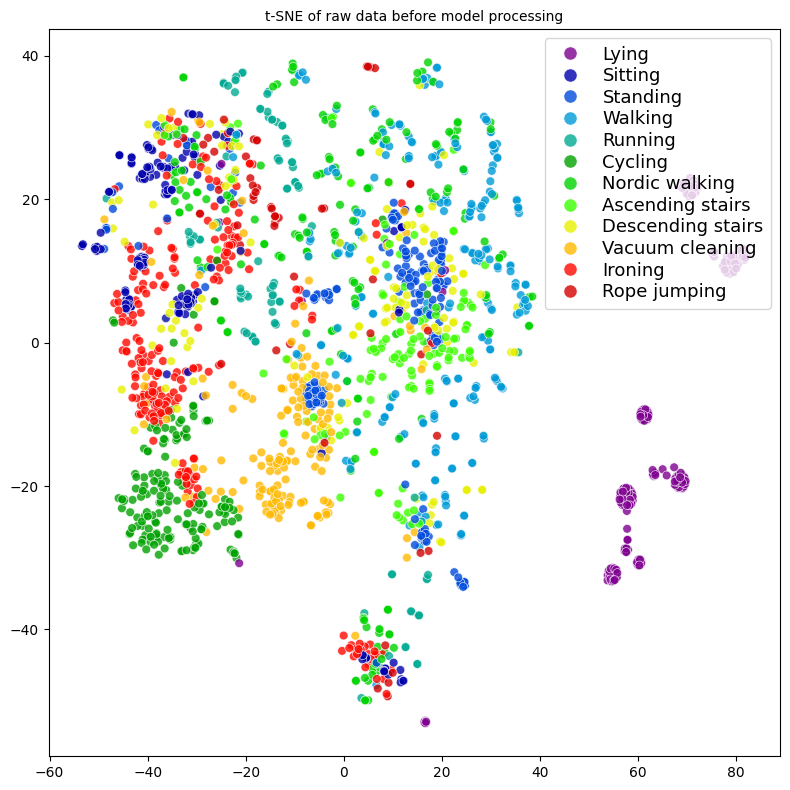


Running t-SNE on 2000 points (Perplexity=30)...


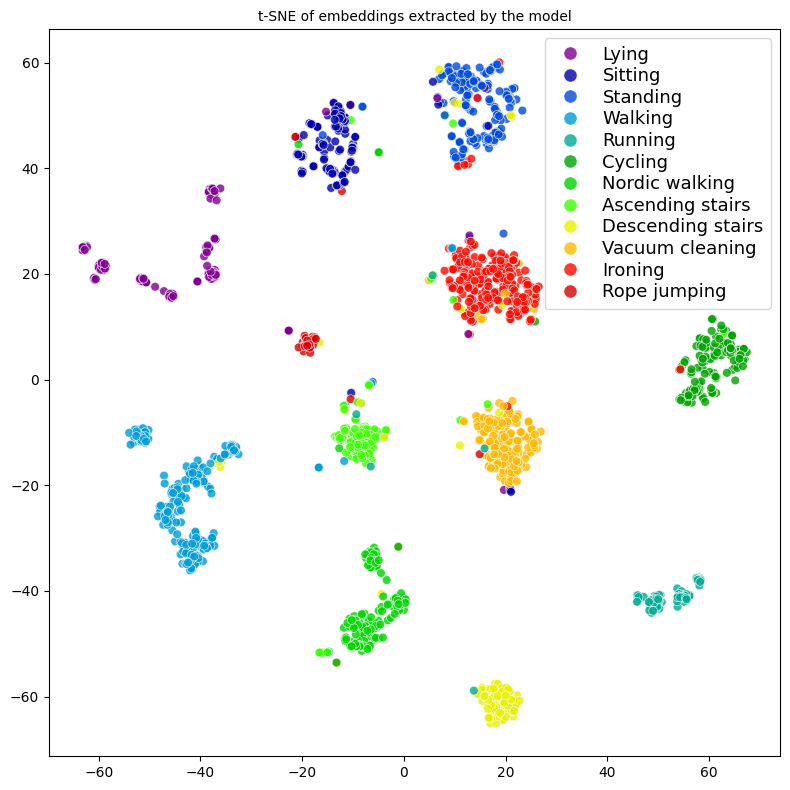

In [2]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
os.environ["PYTHONHASHSEED"] = "789"

import copy, time, warnings, logging, random, re, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE

from fvcore.nn import FlopCountAnalysis


# ------------------------------------------------------------------------------
# 0) Utils
# ------------------------------------------------------------------------------
def set_seed(seed: int, deterministic: bool = True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.use_deterministic_algorithms(True, warn_only=False)


def make_seed_worker(seed: int):
    def seed_worker(worker_id: int):
        worker_seed = seed + worker_id
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    return seed_worker


def evaluate_model_efficiency(model, input_dim=9, seq_len=128, n_runs=300, n_warmup=50):
    print("-" * 80)
    print("Evaluating Model Efficiency...")

    model_cpu = copy.deepcopy(model).to("cpu").eval()
    x = torch.zeros(1, input_dim, seq_len, dtype=torch.float32)

    # (1) Parameters
    params = sum(p.numel() for p in model_cpu.parameters() if p.requires_grad)
    print(f"1. Parameters       : {params/1e6:.4f} M")

    # --- suppress fvcore warnings (clean log) ---
    fv_logger = logging.getLogger("fvcore.nn.jit_analysis")
    old_level = fv_logger.level
    fv_logger.setLevel(logging.ERROR)
    warnings.filterwarnings("ignore")

    # (2) FLOPs / sample (safe)
    try:
        with torch.no_grad():
            flops = FlopCountAnalysis(model_cpu, (x,)).total()
        print(f"2. FLOPs / sample   : {float(flops)/1e6:.3f} M")
    except Exception:
        print("2. FLOPs / sample   : N/A")
    finally:
        fv_logger.setLevel(old_level)

    # (3) CPU inference time (ms/sample)
    with torch.no_grad():
        for _ in range(n_warmup):
            _ = model_cpu(x)

    t0 = time.perf_counter()
    with torch.no_grad():
        for _ in range(n_runs):
            _ = model_cpu(x)
    t1 = time.perf_counter()

    ms_per_sample = (t1 - t0) * 1000.0 / n_runs
    print(f"3. Infer time       : {ms_per_sample:.2f} ms/sample")
    print("-" * 80)

    del model_cpu


ACTIVITY_LABELS = [
    "Lying",
    "Sitting",
    "Standing",
    "Walking",
    "Running",
    "Cycling",
    "Nordic walking",
    "Ascending stairs",
    "Descending stairs",
    "Vacuum cleaning",
    "Ironing",
    "Rope jumping",
]

ACTIVITY_LABELS_CM = [
    "Lying",
    "Sitting",
    "Standing",
    "Walking",
    "Running",
    "Cycling",
    "Nordic walking",
    "Ascending\nstairs",
    "Descending\nstairs",
    "Vacuum\ncleaning",
    "Ironing",
    "Rope\njumping",
]

n_labels = len(ACTIVITY_LABELS)
hsv_colors = sns.color_palette("nipy_spectral", n_colors=n_labels)
ACTIVITY_COLOR_MAP = dict(zip(ACTIVITY_LABELS, hsv_colors))


def plot_classification_results(y_true, y_pred, save_path=None):
    print("\n" + "="*80)
    print("Classification Report")
    print("="*80)
    print(
        classification_report(
            y_true,
            y_pred,
            target_names=ACTIVITY_LABELS,
            digits=4,
            zero_division=0,
        )
    )

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(25, 25))
    ax = sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', square=True,
                annot_kws={"size": 38}, cbar_kws={"shrink": 0.7},
                xticklabels=ACTIVITY_LABELS_CM, yticklabels=ACTIVITY_LABELS_CM)

    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=30)
    plt.xlabel('Predicted Label', fontsize=35)
    plt.ylabel('True Label', fontsize=35)
    plt.title('')
    plt.xticks(rotation=90, ha='right', fontsize=40)
    plt.yticks(rotation=0, fontsize=40)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=600)

    plt.show()
    plt.close()

def _extract_featvec_before_classifier(model, xb, device):
    xb = xb.to(device)
    _, details = model(xb, return_details=True)
    feat_vec = details["h"]
    return feat_vec.detach().cpu()

def plot_tsne_from_cached_features(feats, labels, save_path=None, max_points=2000):
    all_features = feats
    all_labels = labels

    N = all_features.shape[0]
    idx = np.arange(N)
    if N > max_points:
        idx = np.random.choice(N, size=max_points, replace=False)

    X_sel = all_features[idx]
    y_sel = all_labels[idx]

    effective_perp = min(30, len(X_sel) - 1)
    effective_perp = max(effective_perp, 5)

    print(f"\nRunning t-SNE on {len(X_sel)} points (Perplexity={effective_perp})...")

    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=30,
        early_exaggeration=24.0,
        max_iter=4000,
        init="pca",
        learning_rate="auto",
        metric="cosine",
        angle=0.5,
    )
    proj = tsne.fit_transform(X_sel)

    df = pd.DataFrame(proj, columns=["Dim1", "Dim2"])
    df["label"] = [ACTIVITY_LABELS[l] for l in y_sel]

    plt.figure(figsize=(8, 8))
    ax = sns.scatterplot(
        data=df,
        x="Dim1",
        y="Dim2",
        hue="label",
        palette=ACTIVITY_COLOR_MAP,
        hue_order=ACTIVITY_LABELS,
        legend="full",
        alpha=0.8,
        s=40,
    )
    plt.title("t-SNE of embeddings extracted by the model", fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.legend(
        loc="upper right",
        fontsize=13,
        labelspacing=0.2,
        markerscale=1.5
    )
    plt.grid(False)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=300)

    plt.show()
    plt.close()

def visualize_tsne_raw(dataloader, save_path=None, max_points=2000):
    all_raw = []
    all_labels = []

    for xb, yb in dataloader:
        all_raw.append(xb.cpu().numpy())
        all_labels.append(yb.cpu().numpy())

    all_raw = np.concatenate(all_raw, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    N = all_raw.shape[0]
    idx = np.arange(N)
    if N > max_points:
        idx = np.random.choice(N, size=max_points, replace=False)

    X_sel = all_raw[idx]
    y_sel = all_labels[idx]

    X_flat = X_sel.reshape(X_sel.shape[0], -1)

    effective_perp = min(30, len(X_flat) - 1)
    effective_perp = max(effective_perp, 5)

    print(f"\nRunning Raw Data t-SNE on {len(X_sel)} points...")

    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=effective_perp,
        max_iter=2000,
        init="pca",
        learning_rate="auto",
    )
    proj = tsne.fit_transform(X_flat)

    df = pd.DataFrame(proj, columns=["Dim1", "Dim2"])
    df["label"] = [ACTIVITY_LABELS[l] for l in y_sel]

    plt.figure(figsize=(8, 8))
    ax = sns.scatterplot(
        data=df,
        x="Dim1",
        y="Dim2",
        hue="label",
        palette=ACTIVITY_COLOR_MAP,
        hue_order=ACTIVITY_LABELS,
        legend="full",
        alpha=0.8,
        s=40,
    )
    plt.title("t-SNE of raw data before model processing", fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.legend(
        loc="upper right",
        fontsize=13,
        labelspacing=0.2,
        markerscale=1.5
    )
    plt.grid(False)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=300)

    plt.show()
    plt.close()

@torch.no_grad()
def cache_embeddings_from_loader(model, loader, device, max_batches=None):
    model.eval()
    feats_list = []
    labels_list = []

    for b, (xb, yb) in enumerate(loader):
        xb = xb.to(device, non_blocking=True)
        logits, details = model(xb, return_details=True)
        feats_list.append(details["h"].detach().cpu().numpy())
        labels_list.append(yb.numpy())

        if (max_batches is not None) and (b + 1 >= max_batches):
            break

    feats = np.concatenate(feats_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    return feats, labels


# ------------------------------------------------------------------------------
# 1) Dataset
# ------------------------------------------------------------------------------
PAMAP2_FEATURES_27 = [
    # hand
    "handAcc16_1","handAcc16_2","handAcc16_3",
    "handAcc6_1","handAcc6_2","handAcc6_3",
    "handGyro1","handGyro2","handGyro3",

    # chest
    "chestAcc16_1","chestAcc16_2","chestAcc16_3",
    "chestAcc6_1","chestAcc6_2","chestAcc6_3",
    "chestGyro1","chestGyro2","chestGyro3",

    # ankle
    "ankleAcc16_1","ankleAcc16_2","ankleAcc16_3",
    "ankleAcc6_1","ankleAcc6_2","ankleAcc6_3",
    "ankleGyro1","ankleGyro2","ankleGyro3",
]

# acc: (hand acc16+acc6)=6, (chest)=6, (ankle)=6  -> total 18
PAMAP2_ACC_IDX = list(range(0, 6)) + list(range(9, 15)) + list(range(18, 24))

# gyro: hand 6~8, chest 15~17, ankle 24~26 -> total 9
PAMAP2_GYRO_IDX = list(range(6, 9)) + list(range(15, 18)) + list(range(24, 27))

def create_pamap2_windows_no_mag(df: pd.DataFrame, window_size: int, step_size: int):
    feature_cols = PAMAP2_FEATURES_27

    # 12 classes mapping
    old2new = {
        1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5,
        7: 6, 12: 7, 13: 8, 16: 9, 17: 10, 24: 11,
    }
    label_names = [
        "Lying", "Sitting", "Standing", "Walking", "Running", "Cycling",
        "Nordic walking", "Ascending stairs", "Descending stairs",
        "Vacuum cleaning", "Ironing", "Rope jumping",
    ]

    X_list, y_list, subj_list = [], [], []

    for subj_id, g in df.groupby("subject_id"):
        if "timestamp" in g.columns:
            g = g.sort_values("timestamp")
        else:
            g = g.sort_index()

        data_arr  = g[feature_cols].to_numpy(dtype=np.float32)   # (L,C)
        label_arr = g["activityID"].to_numpy(dtype=np.int64)     # (L,)
        L = data_arr.shape[0]

        start = 0
        while start + window_size <= L:
            end = start + window_size
            last_label_orig = int(label_arr[end - 1])

            if last_label_orig == 0 or last_label_orig not in old2new:
                start += step_size
                continue

            window_ct = data_arr[start:end].T  # (C,T)
            X_list.append(window_ct)
            y_list.append(old2new[last_label_orig])
            subj_list.append(int(subj_id))
            start += step_size

    if not X_list:
        raise RuntimeError("No windows created.")

    X = np.stack(X_list, axis=0).astype(np.float32)   # (N,C,T)
    y = np.asarray(y_list, dtype=np.int64)            # (N,)
    subj_ids = np.asarray(subj_list, dtype=np.int64)

    return X, y, subj_ids, label_names


def load_pamap2_windows_27ch(data_dir: str, window_size: int, step_size: int):
    files = glob.glob(os.path.join(data_dir, "*.csv"))
    if len(files) == 0:
        files = glob.glob(os.path.join(data_dir, "*.dat"))
    if len(files) == 0:
        raise RuntimeError(f"No CSV/DAT files found under {data_dir}")

    dfs = []
    for fpath in sorted(files):
        df_i = pd.read_csv(fpath)

        if "subject_id" not in df_i.columns:
            m = re.findall(r"\d+", os.path.basename(fpath))
            subj_guess = int(m[0]) if len(m) > 0 else 0
            df_i["subject_id"] = subj_guess

        dfs.append(df_i)

    df = pd.concat(dfs, ignore_index=True)
    df = df.dropna(subset=["activityID"]).copy()
    df["activityID"] = df["activityID"].astype(np.int64)
    df["subject_id"] = df["subject_id"].astype(np.int64)
    if "timestamp" in df.columns:
        df["timestamp"] = pd.to_numeric(df["timestamp"], errors="coerce")

    feature_cols = PAMAP2_FEATURES_27

    def _fill_subject_group(g):
        if "timestamp" in g.columns:
            g = g.sort_values("timestamp")
        else:
            g = g.sort_index()

        g[feature_cols] = (
            g[feature_cols]
            .interpolate(method="linear", limit_direction="both", axis=0)
            .ffill().bfill()
        )
        return g

    df = df.groupby("subject_id", group_keys=False).apply(_fill_subject_group)
    df[feature_cols] = df[feature_cols].fillna(0.0)

    X, y, subj_ids, label_names = create_pamap2_windows_no_mag(df, window_size, step_size)

    print("=" * 80)
    print("PAMAP2 windows ready (MAG removed)")
    print(f"  X shape : {X.shape} (N,C,T)  C={X.shape[1]}")
    print(f"  y shape : {y.shape} (N,)")
    print(f"  Classes : {len(label_names)}")
    print("=" * 80)

    return X, y, subj_ids, label_names


def fit_transform_scaler_train_only_pamap2_27(train_X, test_X):
    N, C, T = train_X.shape
    N_test = test_X.shape[0]

    train_data = train_X.transpose(0, 2, 1)  # (N,T,C)
    test_data  = test_X.transpose(0, 2, 1)

    train_scaled = train_data.copy()
    test_scaled  = test_data.copy()

    raw_idx  = PAMAP2_ACC_IDX
    rest_idx = PAMAP2_GYRO_IDX

    train_rest = train_data[:, :, rest_idx].reshape(-1, len(rest_idx))
    test_rest  = test_data[:, :, rest_idx].reshape(-1, len(rest_idx))

    scaler = StandardScaler()
    scaler.fit(train_rest)

    train_scaled[:, :, rest_idx] = scaler.transform(train_rest).reshape(N, T, len(rest_idx))
    test_scaled[:, :, rest_idx]  = scaler.transform(test_rest).reshape(N_test, T, len(rest_idx))

    return train_scaled.transpose(0, 2, 1).astype(np.float32), \
           test_scaled.transpose(0, 2, 1).astype(np.float32)


def random_split_np(X, y, test_ratio=0.2, seed=789):
    rng = np.random.RandomState(seed)
    idx = np.arange(len(y))
    rng.shuffle(idx)
    n_test = int(len(idx) * test_ratio)
    test_idx = idx[:n_test]
    train_idx = idx[n_test:]
    return X[train_idx], y[train_idx], X[test_idx], y[test_idx]


class ArrayDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()   # (N, C, T)
        self.y = torch.from_numpy(y).long()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# ------------------------------------------------------------------------------
# 2) Model
# ------------------------------------------------------------------------------
class RelativeEnergyPhysics(nn.Module):
    def __init__(self, acc_indices, gyro_indices):
        super().__init__()
        self.acc_indices = acc_indices
        self.gyro_indices = gyro_indices
        self.m = nn.Parameter(torch.tensor(1.0), requires_grad=True)
        self.I = nn.Parameter(torch.tensor(1.0), requires_grad=True)

    def forward(self, x):  # x: (B, C, T)
        m_pos = F.softplus(self.m)
        I_pos = F.softplus(self.I)

        x_t = x.transpose(1, 2)  # (B, T, C)
        B, T, _ = x_t.shape

        # accel proxy
        if len(self.acc_indices) > 0:
            acc_data = x_t[:, :, self.acc_indices]
            n_acc = len(self.acc_indices) // 3
            if n_acc > 0:
                acc_reshaped = acc_data.view(B, T, n_acc, 3)
                acc_mag = (acc_reshaped ** 2).sum(dim=-1).mean(dim=-1, keepdim=True)  # (B,T,1)
            else:
                acc_mag = torch.zeros(B, T, 1, device=x.device)
        else:
            acc_mag = torch.zeros(B, T, 1, device=x.device)

        E_kin = 0.5 * m_pos * acc_mag

        # gyro proxy
        if len(self.gyro_indices) > 0:
            gyro_data = x_t[:, :, self.gyro_indices]
            n_gyro = len(self.gyro_indices) // 3
            if n_gyro > 0:
                gyro_reshaped = gyro_data.view(B, T, n_gyro, 3)
                gyro_mag = (gyro_reshaped ** 2).sum(dim=-1).mean(dim=-1, keepdim=True)  # (B,T,1)
            else:
                gyro_mag = torch.zeros(B, T, 1, device=x.device)
        else:
            gyro_mag = torch.zeros(B, T, 1, device=x.device)

        E_rot = 0.5 * I_pos * gyro_mag
        return E_kin + E_rot  # (B,T,1)


class PotentialEnergyField(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.energy_net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x, E_phys):  # x:(B,C,T), E_phys:(B,T,1)
        x_t = x.transpose(1, 2)                # (B,T,C)
        x_aug = torch.cat([x_t, E_phys], -1)   # (B,T,C+1)
        return self.energy_net(x_aug)          # (B,T,1)


class EnergyGradientFlow(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.gradient_net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x, E_phys):  # x:(B,C,T), E_phys:(B,T,1)
        x_t = x.transpose(1, 2)                # (B,T,C)
        x_aug = torch.cat([x_t, E_phys], -1)   # (B,T,C+1)
        return self.gradient_net(x_aug)        # (B,T,C)


class RateAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.rate_proj = nn.Linear(hidden_dim, hidden_dim)
        self.rate_gate = nn.Linear(hidden_dim, 1)

    def forward(self, features, energy):  # features:(B,T,H), energy:(B,T,1)
        energy_rate = torch.cat([energy[:, :1, :], energy[:, 1:, :] - energy[:, :-1, :]], dim=1)
        ctx = self.rate_proj(features)
        scores = self.rate_gate(ctx + energy_rate)
        attn = torch.softmax(scores.squeeze(-1), dim=1)
        return attn, features * attn.unsqueeze(-1)


class PhaseAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.phase_proj = nn.Linear(hidden_dim, hidden_dim)
        self.phase_gate = nn.Linear(hidden_dim, 1)

    def forward(self, features, energy):
        energy_pad = F.pad(energy.transpose(1, 2), (1, 1), mode='replicate').transpose(1, 2)
        curv = energy_pad[:, 2:, :] - 2 * energy_pad[:, 1:-1, :] + energy_pad[:, :-2, :]
        ctx = self.phase_proj(features)
        scores = self.phase_gate(ctx + curv)
        attn = torch.softmax(scores.squeeze(-1), dim=1)
        return attn, features * attn.unsqueeze(-1)


class AttentionToAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.meta_attention = nn.Sequential(
            nn.Linear(2, hidden_dim // 4),
            nn.GELU(),
            nn.Linear(hidden_dim // 4, 2),
            nn.Softmax(dim=-1)
        )
        self.conflict_detector = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, rate_attn, phase_attn, rate_feat, phase_feat):
        attn_stack = torch.stack([rate_attn, phase_attn], dim=-1)  # (B,T,2)
        reliability = self.meta_attention(attn_stack)              # (B,T,2)
        rate_reliability = reliability[:, :, 0:1]
        phase_reliability = reliability[:, :, 1:2]

        feat_cat = torch.cat([rate_feat, phase_feat], dim=-1)
        conflict_score = self.conflict_detector(feat_cat).mean(dim=1).squeeze(-1)

        reconciled = rate_reliability * rate_feat + phase_reliability * phase_feat
        return reconciled, conflict_score


class LandscapeGeometryEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        combined_dim = input_dim * 2 + 1
        self.input_proj = nn.Conv1d(combined_dim, hidden_dim, kernel_size=1)
        self.conv = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2)
        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(0.15)
        self.temporal_attn = nn.MultiheadAttention(hidden_dim, num_heads=4, batch_first=True)

        self.rate_attention = RateAttention(hidden_dim)
        self.phase_attention = PhaseAttention(hidden_dim)
        self.a2 = AttentionToAttention(hidden_dim)

    def forward(self, energy, gradient, x_original):
        x_t = x_original.transpose(1, 2)                     # (B,T,C)
        state = torch.cat([x_t, gradient, energy], dim=-1)   # (B,T,2C+1)

        h = self.input_proj(state.transpose(1, 2))           # (B,H,T)
        h = self.conv(h)
        h = self.norm(h.transpose(1, 2)).transpose(1, 2)
        h = F.gelu(h)
        h = self.dropout(h)

        h_t = h.transpose(1, 2)                              # (B,T,H)
        h_t, _ = self.temporal_attn(h_t, h_t, h_t)

        rate_attn, rate_feat = self.rate_attention(h_t, energy)
        phase_attn, phase_feat = self.phase_attention(h_t, energy)
        reconciled, conflict = self.a2(rate_attn, phase_attn, rate_feat, phase_feat)
        return reconciled, conflict


class MIELHAR_A2(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, sensor_config,
                 physics_grad_weight=0.1, energy_reg_weight=0.01):
        super().__init__()
        self.acc_indices = sensor_config["acc_indices"]
        self.gyro_indices = sensor_config["gyro_indices"]

        self.physics = RelativeEnergyPhysics(self.acc_indices, self.gyro_indices)
        self.potential_field = PotentialEnergyField(input_dim, hidden_dim)
        self.gradient_flow   = EnergyGradientFlow(input_dim, hidden_dim)
        self.physics_grad_weight = physics_grad_weight

        self.encoder = LandscapeGeometryEncoder(input_dim, hidden_dim)
        self.energy_reg_weight = energy_reg_weight

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, num_classes),
        )

    def _physics_grad(self, x):
        x_t = x.transpose(1, 2)  # (B,T,C)
        m_pos = F.softplus(self.physics.m)
        I_pos = F.softplus(self.physics.I)

        pg = torch.zeros_like(x_t)
        if len(self.acc_indices) > 0:
            pg[:, :, self.acc_indices] = x_t[:, :, self.acc_indices] * m_pos
        if len(self.gyro_indices) > 0:
            pg[:, :, self.gyro_indices] = x_t[:, :, self.gyro_indices] * I_pos
        return pg

    def forward(self, x, return_energy=False, return_details=False):
        E_phys = self.physics(x)  # (B,T,1)

        energy = self.potential_field(x, E_phys)        # (B,T,1)
        grad   = self.gradient_flow(x, E_phys)          # (B,T,C)
        grad = grad + self.physics_grad_weight * self._physics_grad(x)

        landscape_features, conflict = self.encoder(energy, grad, x)  # (B,T,H)

        g = self.pool(landscape_features.transpose(1, 2)).squeeze(-1)  # (B,H)
        logits = self.classifier(g)

        if return_details:
            details = {
                "h": g,                           # (B,H)  <- t-SNE로 쓰기 좋은 벡터
                "landscape": landscape_features,  # (B,T,H)
                "energy": energy,                 # (B,T,1)
                "grad": grad,                     # (B,T,C)
                "conflict": conflict,             # (B,) or scalar-ish
            }
            if return_energy:
                return logits, energy, grad, details
            return logits, details

        if return_energy:
            return logits, energy, grad
        return logits


def compute_energy_loss(energy, gradient, beta_gradmag=0.1):
    energy_diff = energy[:, 1:] - energy[:, :-1]
    smoothness = torch.mean(energy_diff ** 2)
    grad_mag = torch.norm(gradient, dim=-1)
    grad_loss = torch.mean(grad_mag)
    return smoothness + beta_gradmag * grad_loss


# ------------------------------------------------------------------------------
# 3) Train/Eval
# ------------------------------------------------------------------------------
def train_one_epoch(model, loader, optimizer, criterion, device, beta_gradmag=0.1):
    model.train()

    total_sum = 0.0
    cls_sum = 0.0
    e_sum = 0.0
    n_batches = 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        logits, energy, grad = model(x, return_energy=True)
        cls_loss = criterion(logits, y)
        e_loss = compute_energy_loss(energy, grad, beta_gradmag=beta_gradmag)

        loss = cls_loss + model.energy_reg_weight * e_loss

        loss.backward()
        optimizer.step()

        total_sum += loss.item()
        cls_sum += cls_loss.item()
        e_sum += e_loss.item()
        n_batches += 1

    return {
        "loss_total": total_sum / max(1, n_batches),
        "loss_cls": cls_sum / max(1, n_batches),
        "loss_energy": e_sum / max(1, n_batches),
    }


@torch.no_grad()
def eval_metrics(model, loader, device, class_names=None):
    model.eval()
    all_preds, all_labels = [], []

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        logits = model(x)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(y.numpy())

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_labels)

    macro = f1_score(y_true, y_pred, average="macro")

    return macro


# ------------------------------------------------------------------------------
# 4) Main
# ------------------------------------------------------------------------------
def main():
    CFG = {
        "seed": 789,
        "deterministic": True,

        "dataset_root": "/content/drive/MyDrive/Colab Notebooks/HAR_data",
        "ckpt_save_dir": "/content/drive/MyDrive/Colab Notebooks/A2-MIEL/model_ckpt",
        "plot_save_dir": "/content/drive/MyDrive/Colab Notebooks/A2-MIEL/PAMAP2_plot",

        "window_size": 128,
        "step_size": 64,
        "test_ratio": 0.15,

        "batch_size": 64,
        "num_workers": 2,
        "pin_memory": True,

        "epochs": 100,
        "lr": 5e-4,
        "weight_decay": 3e-4,
        "label_smoothing": 0.05,
        "physics_grad_weight": 0.25,  # EnergyGradientFlow: grad + alpha * physics_grad_weight

        "acc_indices": PAMAP2_ACC_IDX,
        "gyro_indices": PAMAP2_GYRO_IDX,

        # loss weights
        "w_energy_reg": 0.1,      # multiply energy loss
        "beta_gradmag": 0.2,      # compute_energy_loss: smooth + beta * gradmag

        # model
        "hidden_dim": 64,
        "num_classes": 12,
        "input_dim": 27,

        # logging
        "log_every": 10,
    }

    os.makedirs(CFG["ckpt_save_dir"], exist_ok=True)
    os.makedirs(CFG["plot_save_dir"], exist_ok=True)

    best_ckpt_path = os.path.join(CFG["ckpt_save_dir"], "PAMAP2_best.pt")
    cm_path = os.path.join(CFG["plot_save_dir"], "PAMAP2_cm.png")
    raw_tsne_path = os.path.join(CFG["plot_save_dir"], "PAMAP2_raw.png")
    emb_tsne_path = os.path.join(CFG["plot_save_dir"], "PAMAP2_embed.png")

    set_seed(CFG["seed"], CFG["deterministic"])
    seed_worker = make_seed_worker(CFG["seed"])
    g = torch.Generator()
    g.manual_seed(CFG["seed"])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("=" * 80)
    print("MIEL-HAR with Attention-to-Attention (A²)")
    print("=" * 80)
    print(f"Device: {device}\n")

    # 1) load windows (N,27,T)
    X_all, y_all, _, label_names = load_pamap2_windows_27ch(
        data_dir=CFG["dataset_root"],
        window_size=CFG["window_size"],
        step_size=CFG["step_size"],
    )

    # 2) random split
    X_train, y_train, X_test, y_test = random_split_np(
        X_all, y_all,
        test_ratio=CFG["test_ratio"],
        seed=CFG["seed"],
    )

    # 3) train-only scale
    X_train_s, X_test_s = fit_transform_scaler_train_only_pamap2_27(X_train, X_test)

    train_ds = ArrayDataset(X_train_s, y_train)
    test_ds  = ArrayDataset(X_test_s, y_test)

    train_loader = DataLoader(
        train_ds,
        batch_size=CFG["batch_size"],
        shuffle=True,
        num_workers=CFG["num_workers"],
        pin_memory=CFG["pin_memory"] and (device.type == "cuda"),
        worker_init_fn=seed_worker,
        generator=g,
        drop_last=False,
        persistent_workers=(CFG["num_workers"] > 0),
    )
    test_loader = DataLoader(
        test_ds,
        batch_size=CFG["batch_size"],
        shuffle=False,
        num_workers=CFG["num_workers"],
        pin_memory=CFG["pin_memory"] and (device.type == "cuda"),
        worker_init_fn=seed_worker,
        generator=g,
        drop_last=False,
        persistent_workers=(CFG["num_workers"] > 0),
    )

    sensor_config = {"acc_indices": CFG["acc_indices"], "gyro_indices": CFG["gyro_indices"]}

    model = MIELHAR_A2(
        input_dim=CFG["input_dim"],
        hidden_dim=CFG["hidden_dim"],
        num_classes=CFG["num_classes"],
        sensor_config=sensor_config,
        physics_grad_weight=CFG["physics_grad_weight"],
        energy_reg_weight=CFG["w_energy_reg"],
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"])

    warmup_epochs = 5
    warmup_scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        start_factor=0.1,
        end_factor=1.0,
        total_iters=warmup_epochs
    )

    criterion = nn.CrossEntropyLoss(label_smoothing=CFG["label_smoothing"])

    best_test_f1 = -1.0
    best_state = None
    best_epoch = -1

    print("-" * 80)
    print(f"{'Epoch':<8} {'LR':<10} {'Total':<10} {'Cls':<10} {'E':<10} {'TestF1(macro)':<14} {'Best':<6}")
    print("-" * 80)

    for epoch in range(1, CFG["epochs"] + 1):
        train_logs = train_one_epoch(
            model=model,
            loader=train_loader,
            optimizer=optimizer,
            criterion=criterion,
            device=device,
            beta_gradmag=CFG["beta_gradmag"],
        )

        if epoch <= warmup_epochs:
            warmup_scheduler.step()
        lr = optimizer.param_groups[0]["lr"]

        test_f1 = eval_metrics(model, test_loader, device)

        is_best = ""
        if test_f1 > best_test_f1 + 1e-12:
            best_test_f1 = test_f1
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            best_epoch = epoch
            is_best = "*"

            torch.save(
                {
                    "epoch": best_epoch,
                    "best_test_f1": float(best_test_f1),
                    "model_state": best_state,
                    "cfg": CFG,
                },
                best_ckpt_path
            )

        if (epoch % CFG["log_every"]) == 0:
            print(f"{epoch:<8} {lr:<10.6f} "
                  f"{train_logs['loss_total']:<10.4f} {train_logs['loss_cls']:<10.4f} {train_logs['loss_energy']:<10.4f} "
                  f"{test_f1:<14.4f} {is_best:<6}")

    print("-" * 80)
    print(f"Best Test F1(macro): {best_test_f1:.4f} @ epoch {best_epoch}")

    # final confirm
    model.load_state_dict(best_state)

    evaluate_model_efficiency(model, input_dim=CFG["input_dim"], seq_len=128)

    class_names = ACTIVITY_LABELS
    final_test_f1 = eval_metrics(model, test_loader, device, class_names=class_names)
    print("=" * 80)

    # 1) Confusion matrix plot
    y_true_all = []
    y_pred_all = []
    model.eval()
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device, non_blocking=True)
            logits = model(xb)
            pred = torch.argmax(logits, dim=1).cpu().numpy()
            y_pred_all.append(pred)
            y_true_all.append(yb.numpy())

    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)

    plot_classification_results(y_true_all, y_pred_all, save_path=cm_path)

    # 2) Raw t-SNE (test set)
    visualize_tsne_raw(test_loader, save_path=raw_tsne_path, max_points=2000)

    # 3) Embedding t-SNE (test set)
    feats, labs = cache_embeddings_from_loader(model, test_loader, device)
    plot_tsne_from_cached_features(feats, labs, save_path=emb_tsne_path, max_points=2000)

if __name__ == "__main__":
    main()